In [1]:
import os
if not os.path.exists('open-images-bus-trucks'):
    !pip install -q torch_snippets
    !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
    !tar -xf open-images-bus-trucks.tar.xz
    !rm open-images-bus-trucks.tar.xz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 35.2 MB/s eta 0:00

In [2]:
import collections, os, torch
from PIL import Image
from torchvision import transforms
from torch_snippets import *

In [3]:
DATA_ROOT = 'open-images-bus-trucks'
IMAGE_ROOT = f'{DATA_ROOT}/images'
DF_RAW = df = pd.read_csv(f'{DATA_ROOT}/df.csv')
DF_RAW.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [4]:
df = df[df['ImageID'].isin(df['ImageID'].unique().tolist())]

label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)



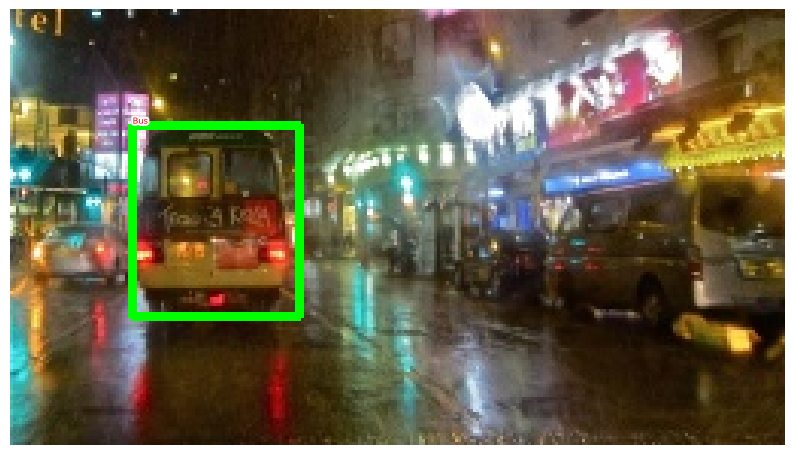

In [5]:
image_id="00010bf498b64bab"
image_path = os.path.join(IMAGE_ROOT,image_id+'.jpg')
image = cv2.imread(image_path, 1)[...,::-1] # conver BGR to RGB
h, w, _ = image.shape

df = DF_RAW[DF_RAW['ImageID'] == image_id]
boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
classes = df['LabelName'].values.tolist()
show(image, bbs=boxes, texts=classes, sz=10)

In [6]:
fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

aspect_ratios = {'conv4_3': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

fmaps = list(fmap_dims.keys())

prior_boxes = []
prior_boxes_info = []

for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * np.sqrt(ratio), obj_scales[fmap] / np.sqrt(ratio)])
                        prior_boxes_info.append([fmap, i, j, ratio])

                        # For an aspect ratio of 1, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 1.:
                            try:
                                additional_scale = np.sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            # For the last feature map, there is no "next" feature map
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])
                            prior_boxes_info.append([fmap, i, j, ratio])



In [7]:
def cxcy_to_xy(cxcy):
    """
    Convert bounding boxes from center-size coordinates (c_x, c_y, w, h) to boundary coordinates (x_min, y_min, x_max, y_max).

    :param cxcy: bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    :return: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
                      cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1)  # x_max, y_max

In [8]:
prior_boxes = torch.FloatTensor(prior_boxes)  # (8732, 4)
prior_boxes.clamp_(0, 1)  # (8732, 4)

tensor([[0.0132, 0.0132, 0.1000, 0.1000],
        [0.0132, 0.0132, 0.1414, 0.1414],
        [0.0132, 0.0132, 0.1414, 0.0707],
        ...,
        [0.5000, 0.5000, 1.0000, 1.0000],
        [0.5000, 0.5000, 1.0000, 0.6364],
        [0.5000, 0.5000, 0.6364, 1.0000]])

In [9]:
priors_xy = cxcy_to_xy(prior_boxes).numpy()

In [10]:
prior_boxes

tensor([[0.0132, 0.0132, 0.1000, 0.1000],
        [0.0132, 0.0132, 0.1414, 0.1414],
        [0.0132, 0.0132, 0.1414, 0.0707],
        ...,
        [0.5000, 0.5000, 1.0000, 1.0000],
        [0.5000, 0.5000, 1.0000, 0.6364],
        [0.5000, 0.5000, 0.6364, 1.0000]])

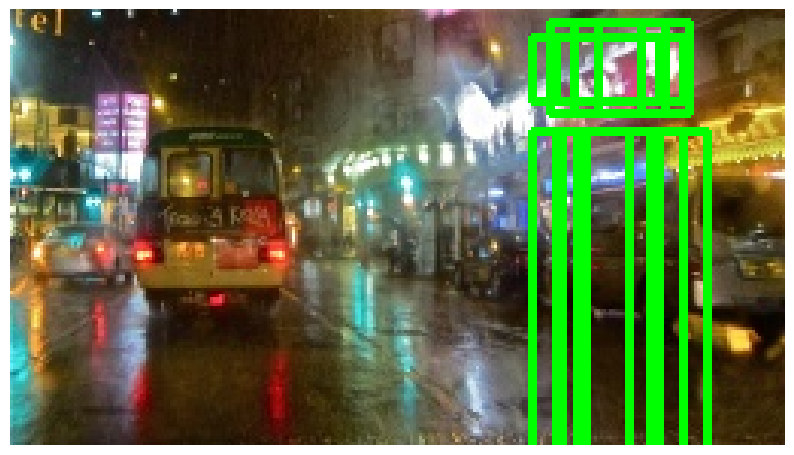

In [13]:
start=40
show(image, bbs=priors_xy[start*10:(start+1)*10]*300, sz=10)